In [1]:
from genelens.fselector import FeatureSelector, get_feature_space, fsplot
from genelens import netanalyzer, enrichment
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from importlib.resources import files

In [2]:
# data load
data = pd.read_csv(files("genelens").joinpath("data/exampl_data/train_test.csv"), index_col=0)

X = data.drop('index', axis=1)
y = list(map(int, data['index'] == 'HCM'))

print(X.shape)

(145, 14830)


In [4]:
# FeatureSelector initialization
FS_model = FeatureSelector(X, y,
                           C = None, 
                           C_space=np.linspace(0.0001, 1, 20), #bigger space -> more precision, more processor time
                           C_finder_iter=10,
                           cut_off_frac_estimation=True,
                           cut_off_frac_model=0,
                           cut_off_estim_params={'max_feature': 50}) # This parameter implements early stopping. Bigger feature space -> more precision, more processor time

The regularization coefficient was not specified, the search for the optimal C was started


processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:20<00:00, 14.07s/it]


Optimal regularization coefficient (С) =  0.053

Prefit model for cutoff weight level estimation


fit model: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [12:38<00:00,  3.95it/s]


Prefit done
Serching cutoff level for feature weights... 0 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:51,  3.59it/s]


1 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:51,  3.60it/s]


2 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:51,  3.59it/s]


3 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:51,  3.59it/s]


4 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:51,  3.61it/s]


5 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:52,  3.57it/s]


6 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:51,  3.60it/s]


7 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:52,  3.57it/s]


8 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:51,  3.61it/s]


9 

feature space analysis:  13%|██████████████████▌                                                                                                                               | 27/213 [00:07<00:52,  3.56it/s]

optimal cut of weight level =  0.72


In [33]:
FS_model.fit(max_iter=2700, log=True, feature_resample=0) #more max_iter -> more precision, more processor time

fit model: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [11:20<00:00,  3.97it/s]


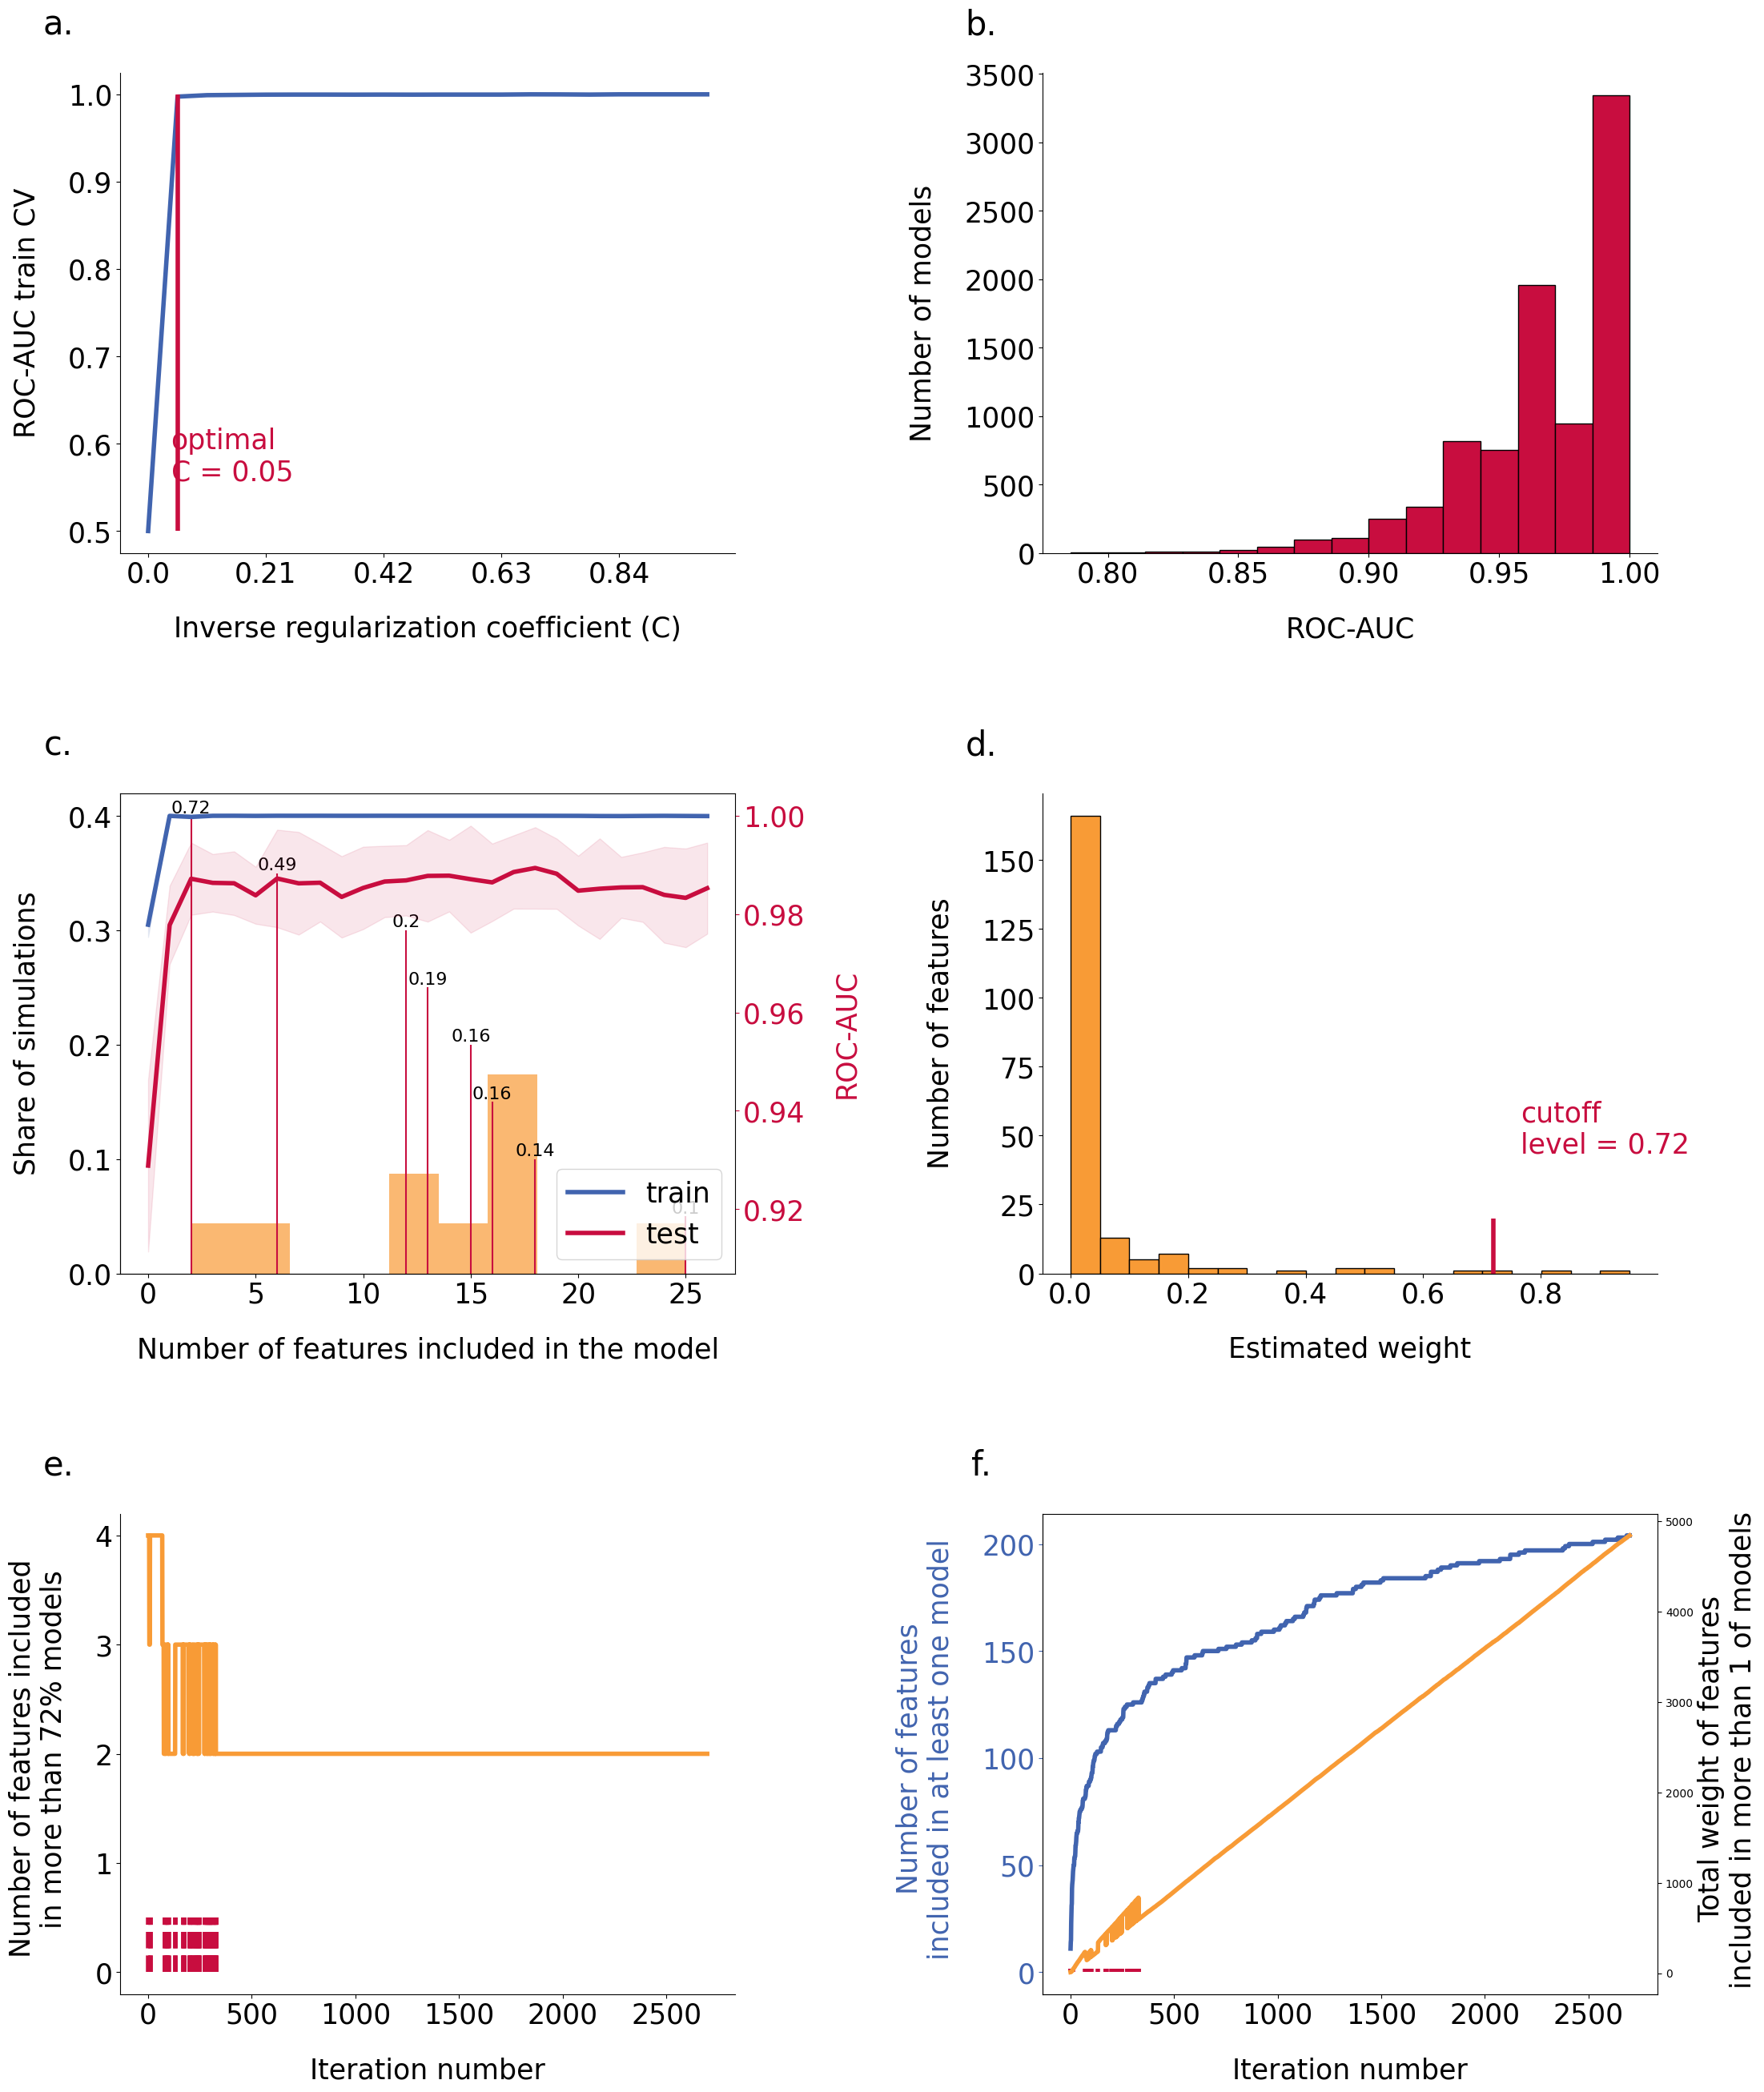

In [34]:
fsplots = fsplot(FS_model)
fsplots.plot_all(fontsize=25, labels=['a.', 'b.', 'c.', 'd.', 'e.', 'f.'], 
                left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5, wspace=0.5)
plt.show()

In [36]:
print(get_feature_space([FS_model], cut_off_level=0.75))

{'MYH6', 'RASD1'}


In [37]:
FS_model.best_features

{'RASD1': np.float64(0.9510623822037754),
 'MYH6': np.float64(0.8420449794132905)}

## Network Enrichment Analysis

In [20]:
GenGenNetwork = netanalyzer.MainNet() #Load String db and create gene-gene interaction network
GenGenNetwork.get_LCC() #get the largest connected component from the network

LCC was extracted
Total connected components=146, LCC cardinality=9844


In [21]:
GenGenNetwork.minimum_connected_subgraph(FS_model.best_features)

RASD1 absent from LCC, excluded from further analysis
CDC42EP4 absent from LCC, excluded from further analysis

mst-graph was extracted
Initial core feature=1, mst-graph cardinality=0


#### Two of the three selected genes are missing from the version of the String database we are using. Therefore, it is not possible to construct an mst-graph. To continue the analysis, we will select the top 10 genes sorted by their Score

In [29]:
GenGenNetwork.minimum_connected_subgraph(dict(list(FS_model.all_features.items())[:10]))

RASD1 absent from LCC, excluded from further analysis
CDC42EP4 absent from LCC, excluded from further analysis
ZFP36 absent from LCC, excluded from further analysis

mst-graph was extracted
Initial core feature=7, mst-graph cardinality=17


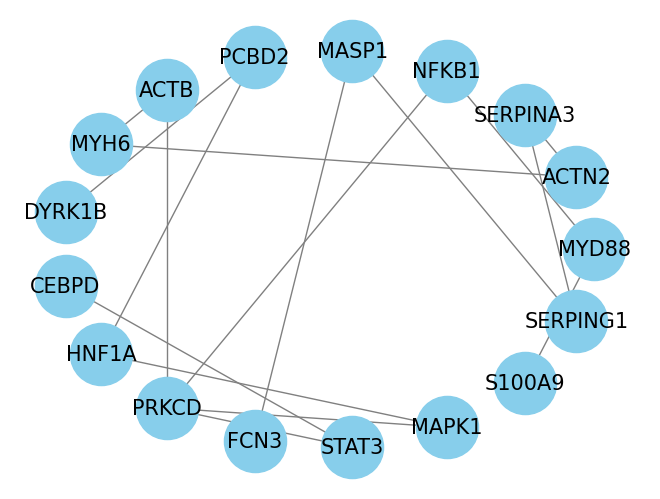

In [32]:
pos = nx.circular_layout(GenGenNetwork.mst_subgraph)

nx.draw(
    GenGenNetwork.mst_subgraph,
    pos,
    with_labels=True,       
    node_color='skyblue',   
    edge_color='gray',      
    node_size=2000,         
    font_size=15            
)

# Показываем граф
plt.show()

<Figure size 2400x2400 with 0 Axes>

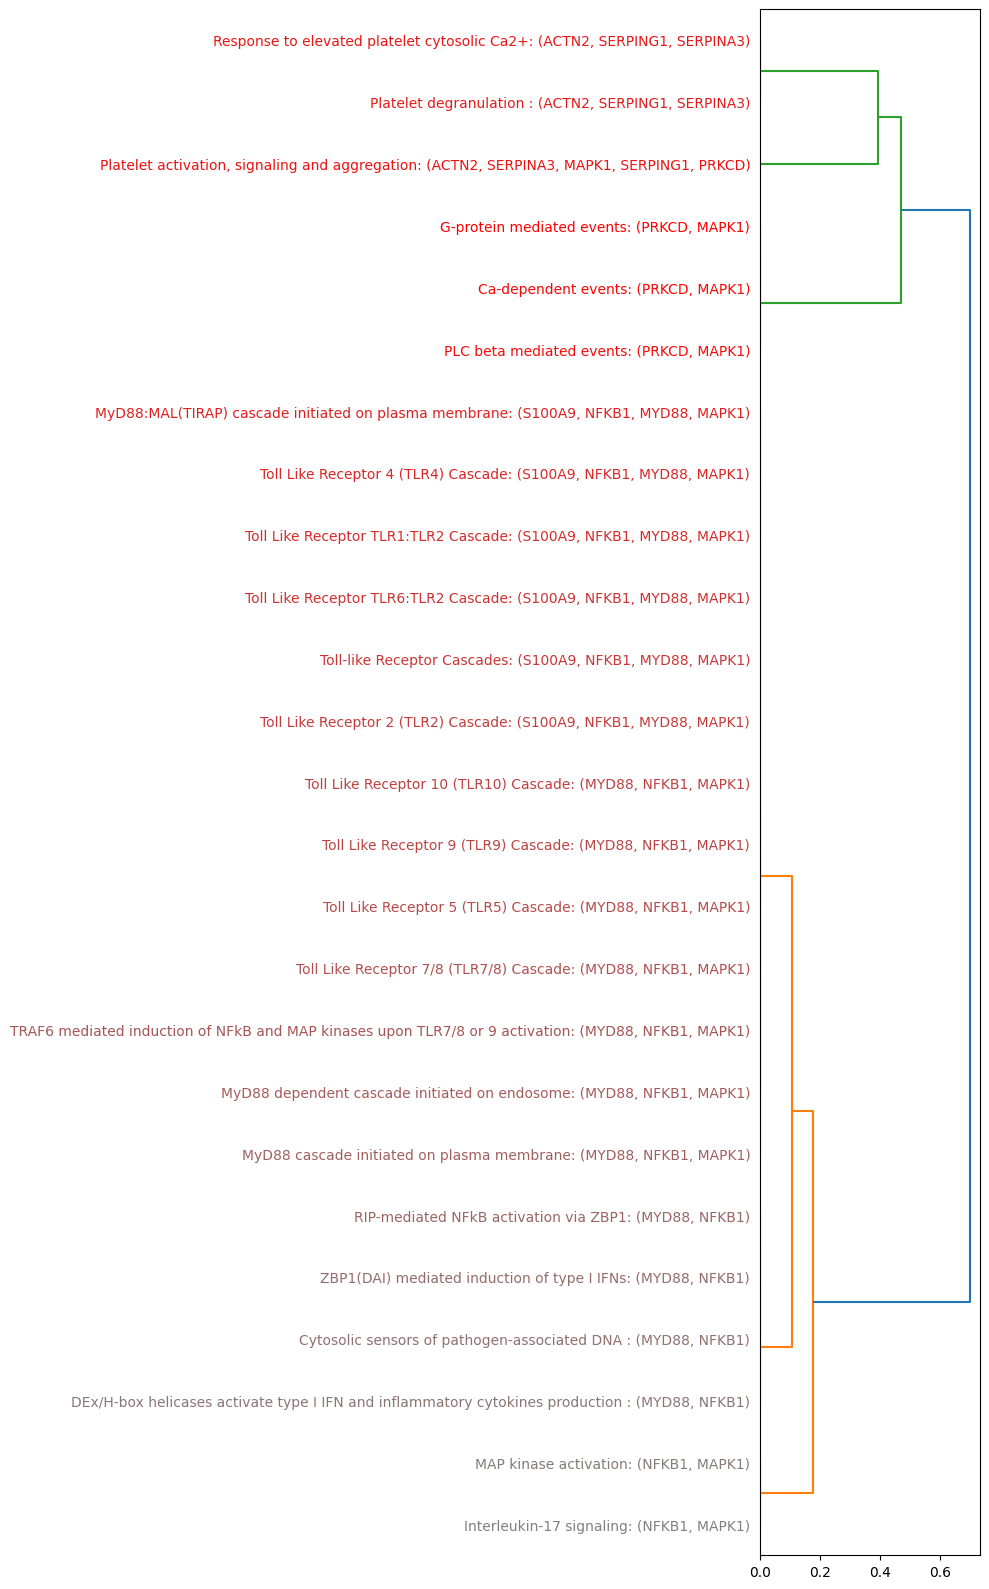

In [31]:
enrichment.dendro_reactome_plot(list(GenGenNetwork.mst_subgraph.nodes()), species='Homo sapiens', FS_model.all_features)

#### The color gradient from gray to red in the signatures reflects the increase in the weight of genes according to their calculated Score. The redder the signature, the higher the weight.